In [1]:
import datetime
import os
import time
from pathlib import Path
from typing import Dict, List, Optional, Union
import PIL
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import utils as vutils
from dataset import EMnistDataset
import struct

gen_img_root = Path("CGAN_bonus/images")
weights_root = Path("CGAN_bonus/weights")
gen_img_root.mkdir(parents=True, exist_ok=True)
weights_root.mkdir(parents=True, exist_ok=True)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

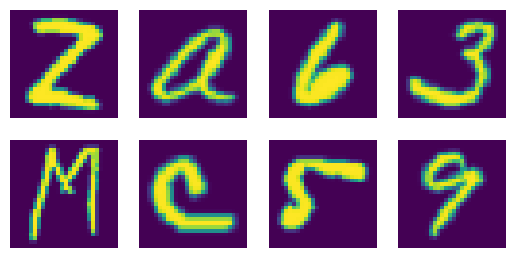

In [2]:
fig, axs = plt.subplots(3, 4)
images = np.load('emnist_img.npy')[:8]
for i, ax in enumerate(axs.flatten()):
    if i < len(images):
        ax.imshow(images[i])
        ax.axis('off')
    else:
        ax.remove()
plt.show()

In [3]:
label = np.load('emnist_label.npy')
print(label.shape, label[0:8])

(697932,) [35 36  6  3 22 38  5  9]


In [4]:
datapath = {'img': 'emnist_img.npy',
            'label':"emnist_label.npy"}

In [5]:
bonus_classes = [10,11,13,14,15,16,17,23,26,27,29]

In [6]:
class Parse:
    def __init__(self) -> None:
        self.n_epochs = 100
        self.batch_size = 64
        self.lr = 1e-3
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.latent_dim = 100
        self.img_size = 32
        self.channels = 1
        self.sample_interval = 2000
        self.n_classes = 62


opt = Parse()

In [7]:
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cuda = True if torch.cuda.is_available() else False
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 0 NVIDIA GeForce RTX 3080


In [8]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

img_shape = (opt.channels, opt.img_size, opt.img_size)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(opt.n_classes, opt.n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim + opt.n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(opt.n_classes, opt.n_classes)

        self.model = nn.Sequential(
            nn.Linear(opt.n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

In [9]:
from torchvision.transforms import InterpolationMode
# Loss function
adversarial_loss = torch.nn.BCEWithLogitsLoss().to(device)

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Configure data loader
dataloader = DataLoader(
    EMnistDataset(datapath,
                  transform=transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(size=[32,32], interpolation=InterpolationMode.BICUBIC),
                                                transforms.Normalize([0.5], [0.5])]),
                    bonus = True),
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

# record trianing loss
record: Dict[str, List[float]] = {"D_loss": [], "G_loss": []}

In [10]:
def show_images(real_imgs, fake_imgs: None, nrow=6, ncol=6, figsize=(10, 10), save: bool = False, show: bool = True, name=""):
    # compare and show n*m images from generator in one figure and optionally save it
    for imgs, label in zip([imgs for imgs in [real_imgs, fake_imgs] if fake_imgs is not None], ["real", "fake"]):
        imgs = imgs[:nrow * ncol]
        
        imgs = imgs.view(imgs.size(0), opt.channels, opt.img_size, opt.img_size)
        plt.figure(figsize=figsize)
        plt.imshow(np.transpose(vutils.make_grid(imgs, nrow=nrow, padding=2, normalize=True).cpu(), (1, 2, 0)))
        plt.axis('off')
        plt.title(name + label + " images")
        if save:
            plt.savefig(gen_img_root / (name + label + " images.png"))
        if show:
            plt.show()


def to_td(second: Union[int, float]) -> str:
    # convert seconds to time delta
    return str(datetime.timedelta(seconds=int(second)))

 E001B001, [0:00:00/14:58:32]  0.57s/epoch D_loss: 0.6889 = r0.6819 + f0.6959  G_loss: 0.6899

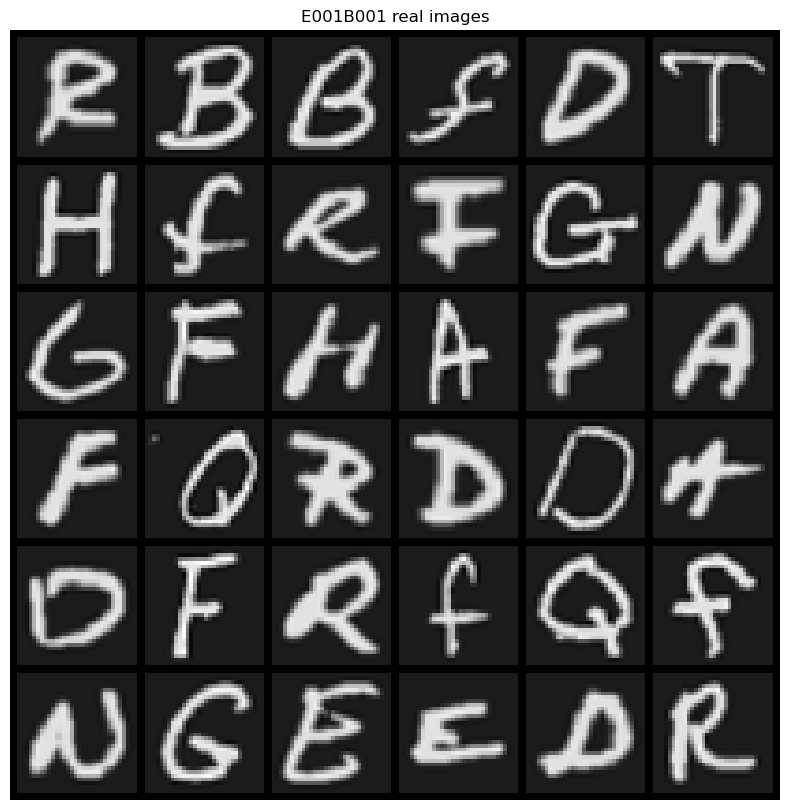

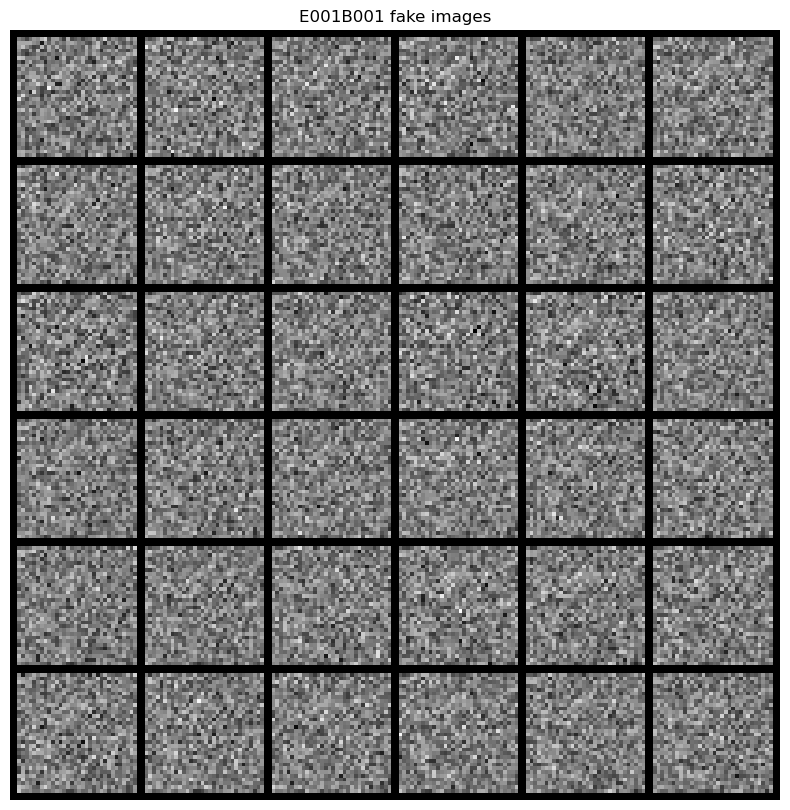

 E001B925, [0:00:17/0:29:10]  8.67s/epoch D_loss: 0.2849 = r0.3426 + f0.2273  G_loss: 2.8300

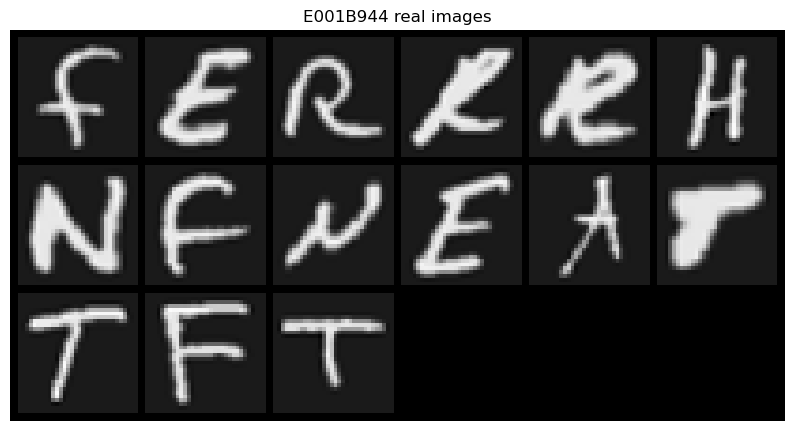

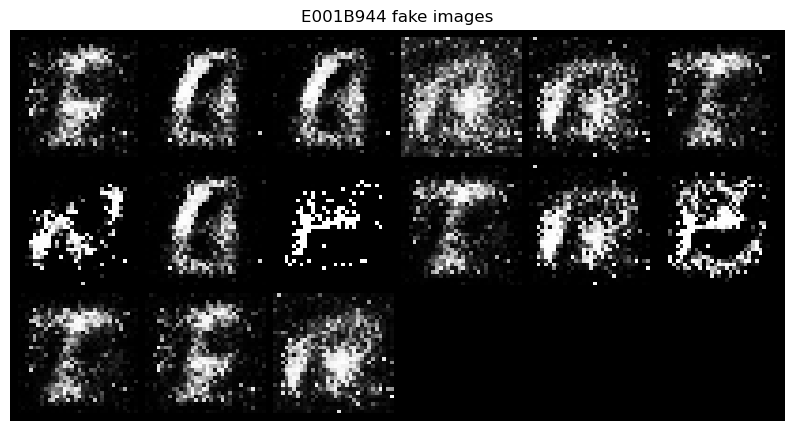

 E010B934, [0:02:45/0:27:41] 15.10s/epoch D_loss: 0.2560 = r0.0832 + f0.4288  G_loss: 1.9856

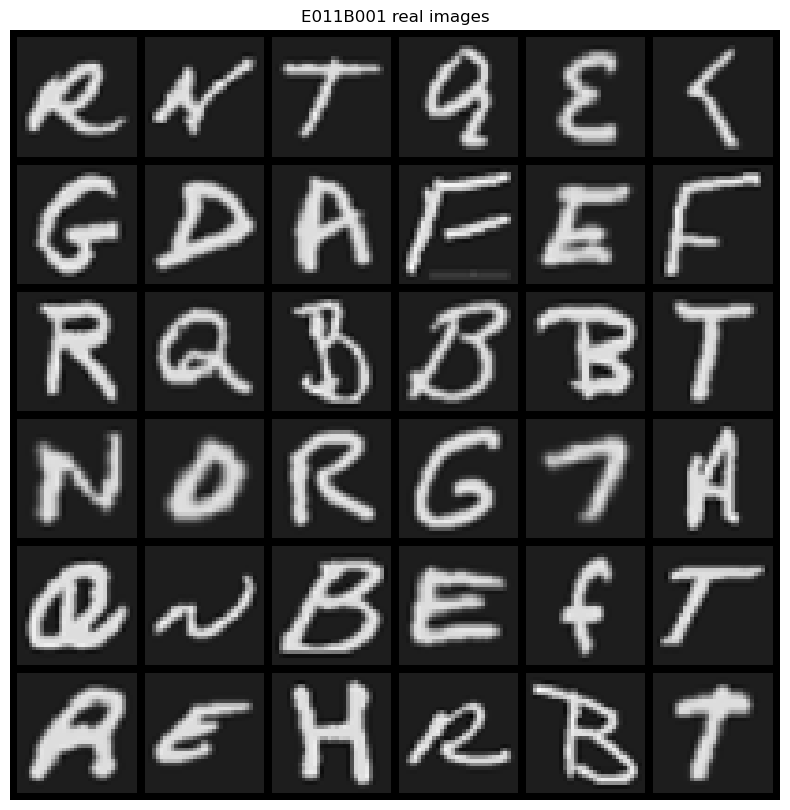

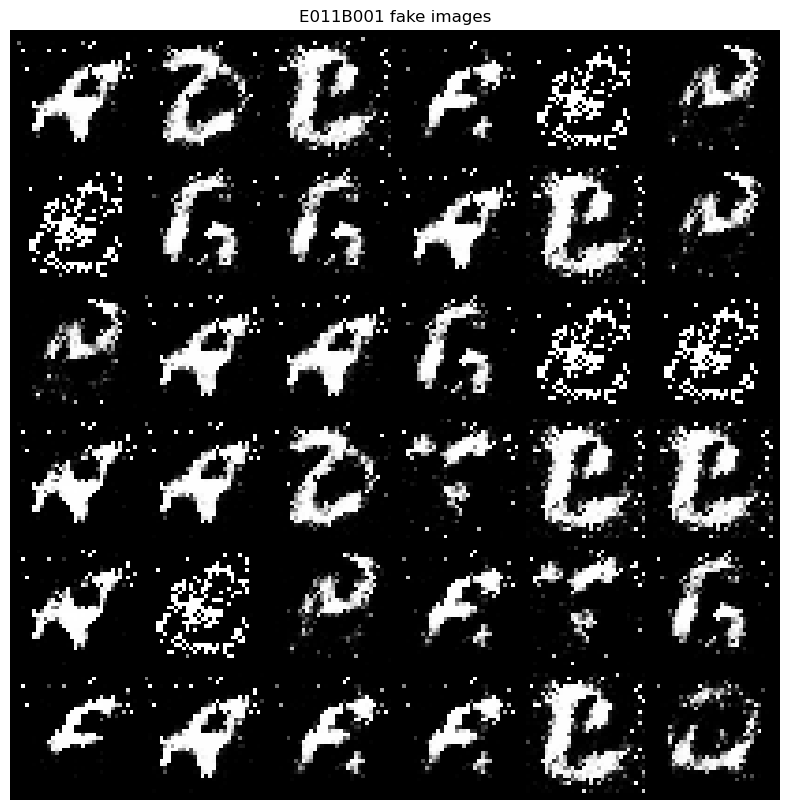

 E011B935, [0:03:02/0:27:44] 15.25s/epoch D_loss: 0.1472 = r0.0375 + f0.2570  G_loss: 2.7596

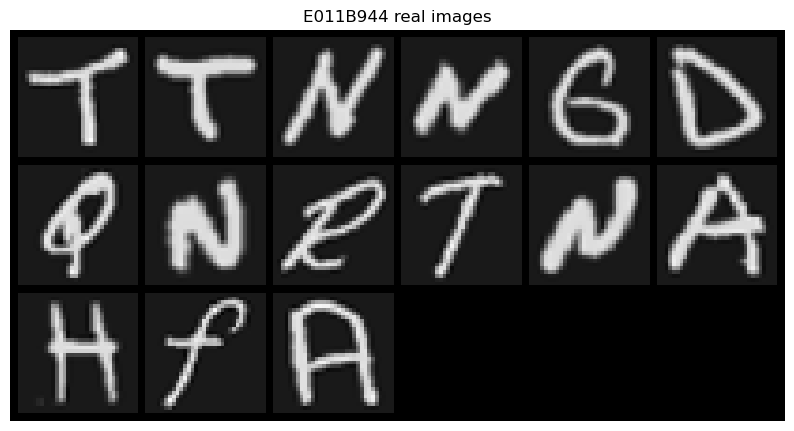

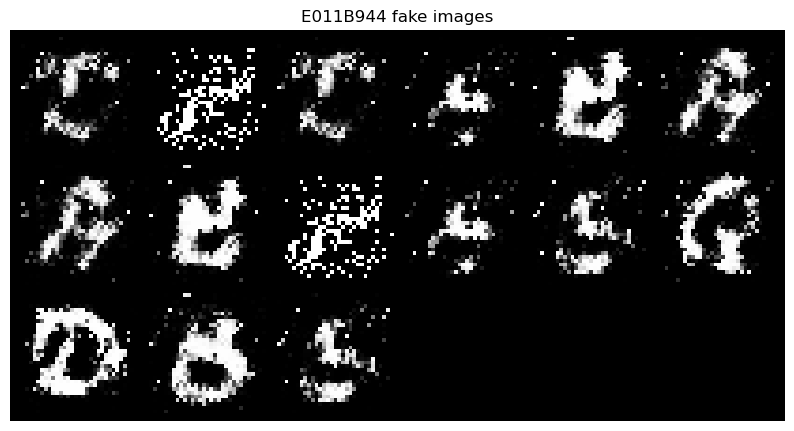

 E020B944, [0:05:30/0:27:34] 15.76s/epoch D_loss: 0.6521 = r1.2916 + f0.0127  G_loss: 5.0925

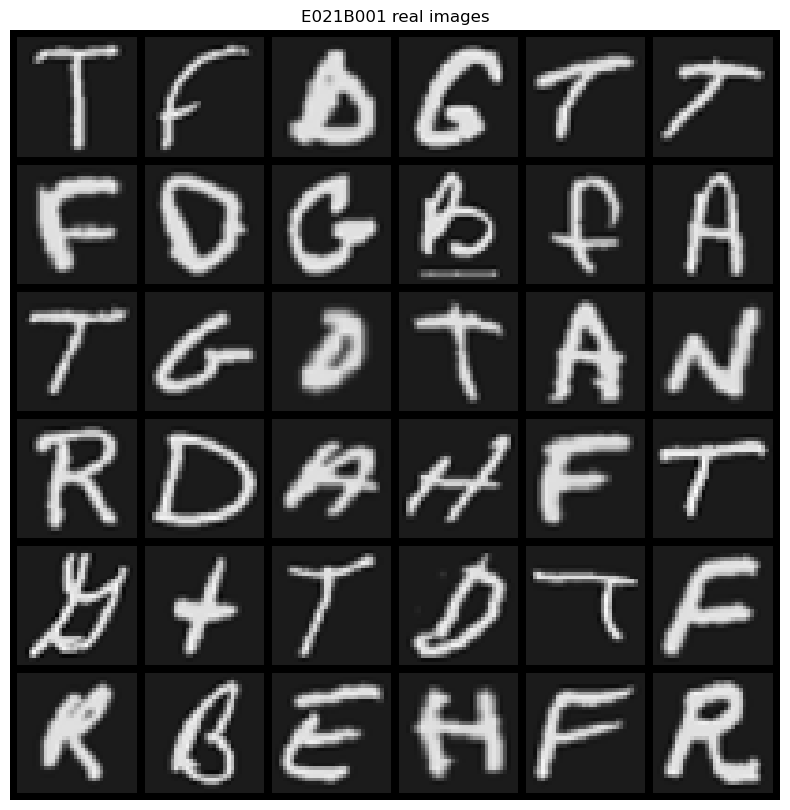

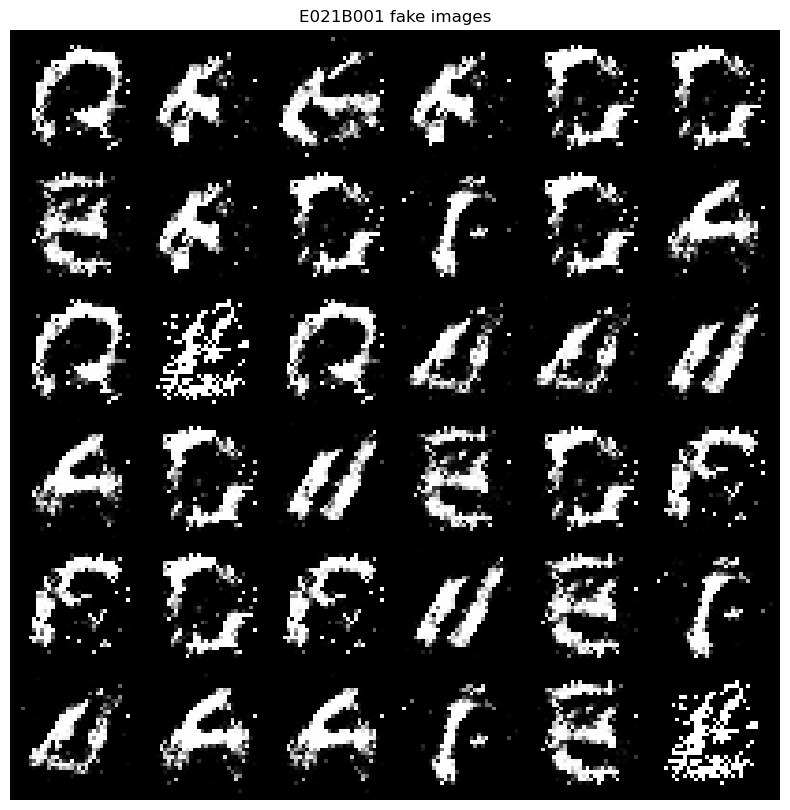

 E021B924, [0:05:47/0:27:35] 15.80s/epoch D_loss: 0.2427 = r0.4734 + f0.0120  G_loss: 5.5620

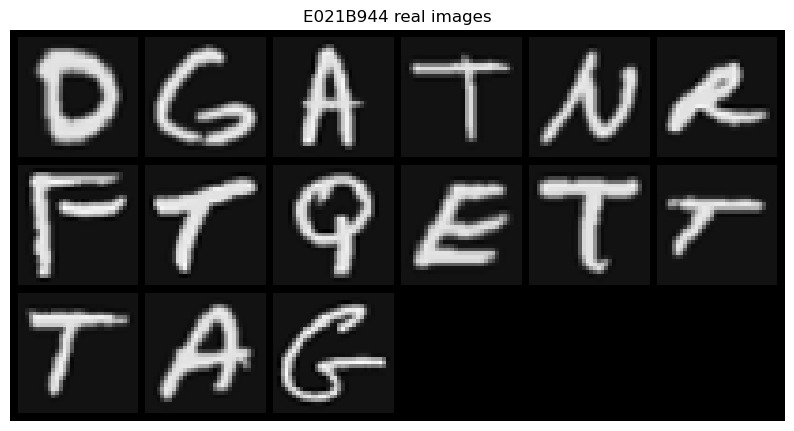

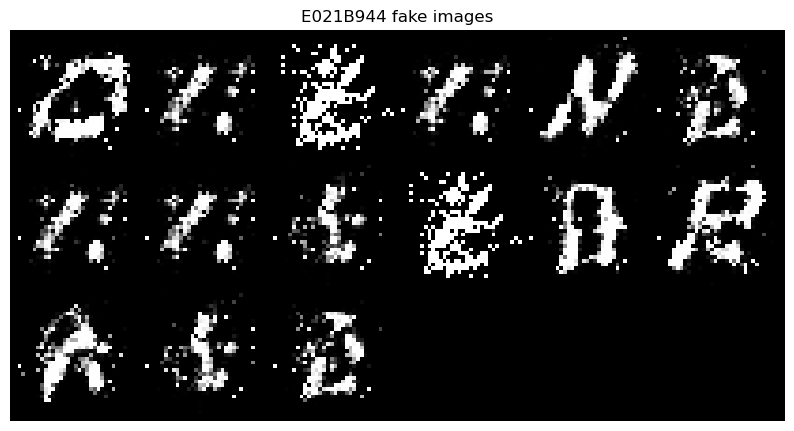

 E030B933, [0:08:14/0:27:29] 15.96s/epoch D_loss: 0.3328 = r0.6616 + f0.0040  G_loss: 6.3825

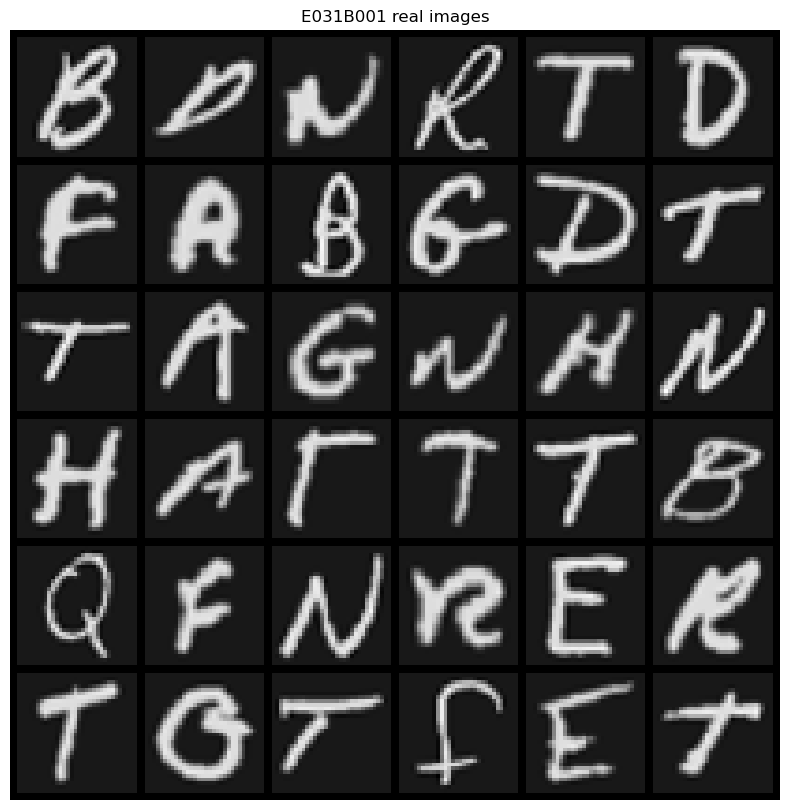

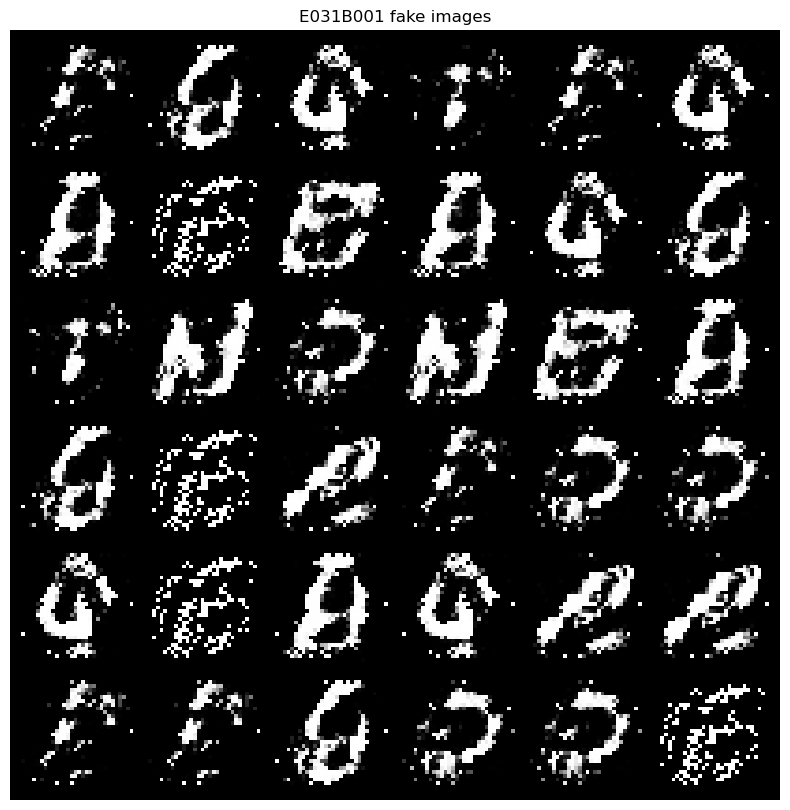

 E031B934, [0:08:31/0:27:31] 15.99s/epoch D_loss: 0.2268 = r0.3817 + f0.0718  G_loss: 4.7640

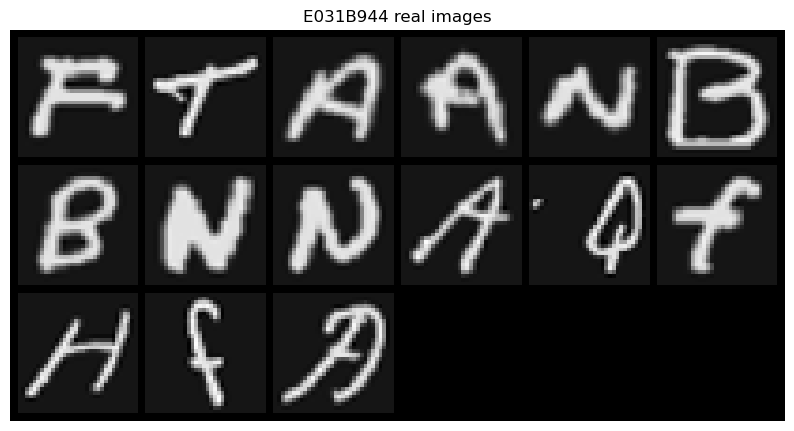

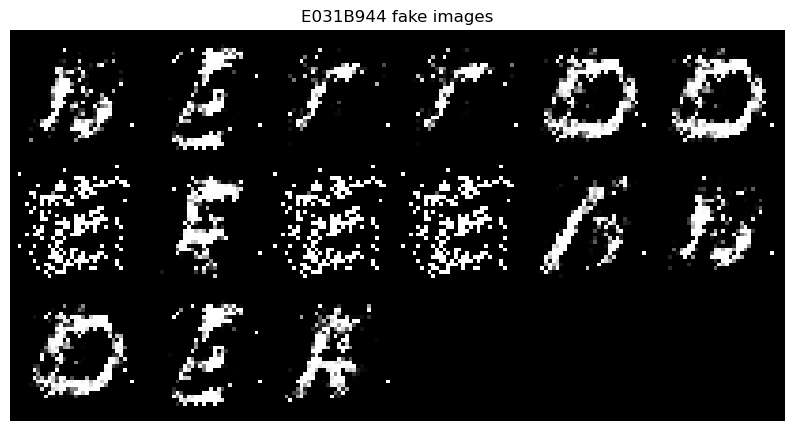

 E040B943, [0:11:01/0:27:34] 16.14s/epoch D_loss: 0.3322 = r0.6601 + f0.0043  G_loss: 6.5955

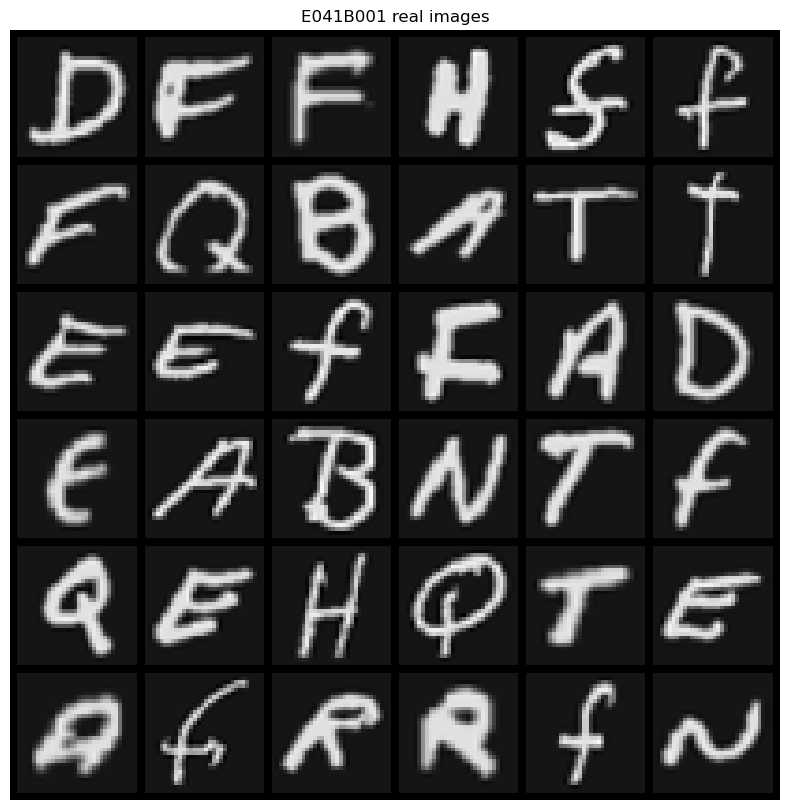

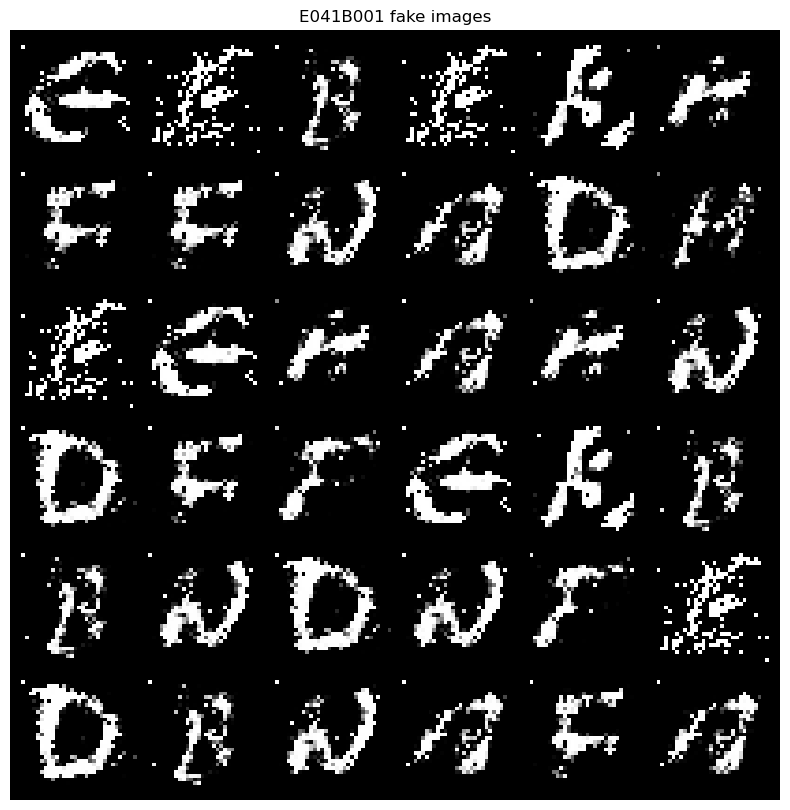

 E041B944, [0:11:18/0:27:35] 16.16s/epoch D_loss: 0.4885 = r0.2953 + f0.6817  G_loss: 1.9304

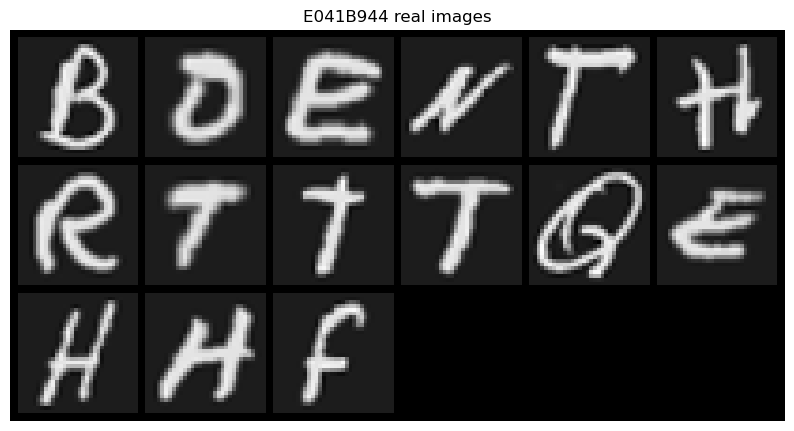

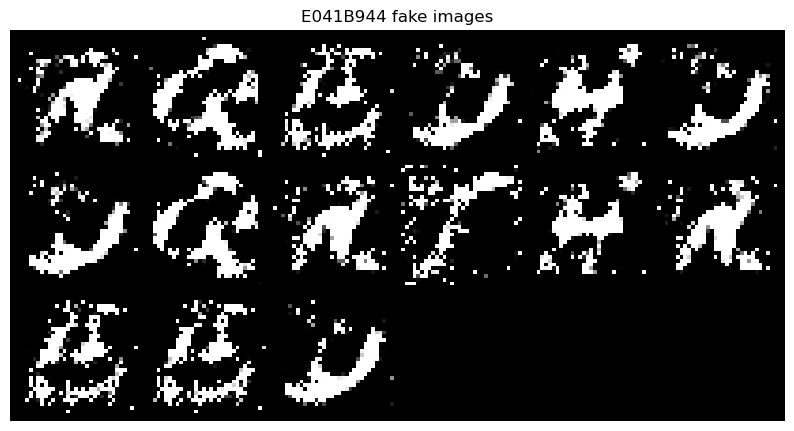

 E050B932, [0:13:46/0:27:33] 16.21s/epoch D_loss: 0.1399 = r0.2559 + f0.0239  G_loss: 5.55514

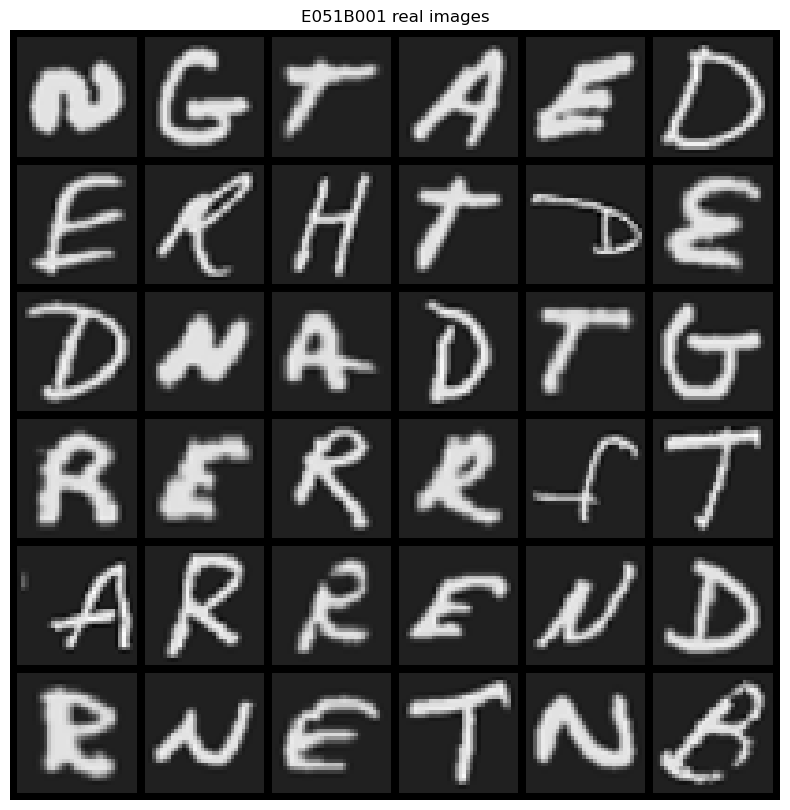

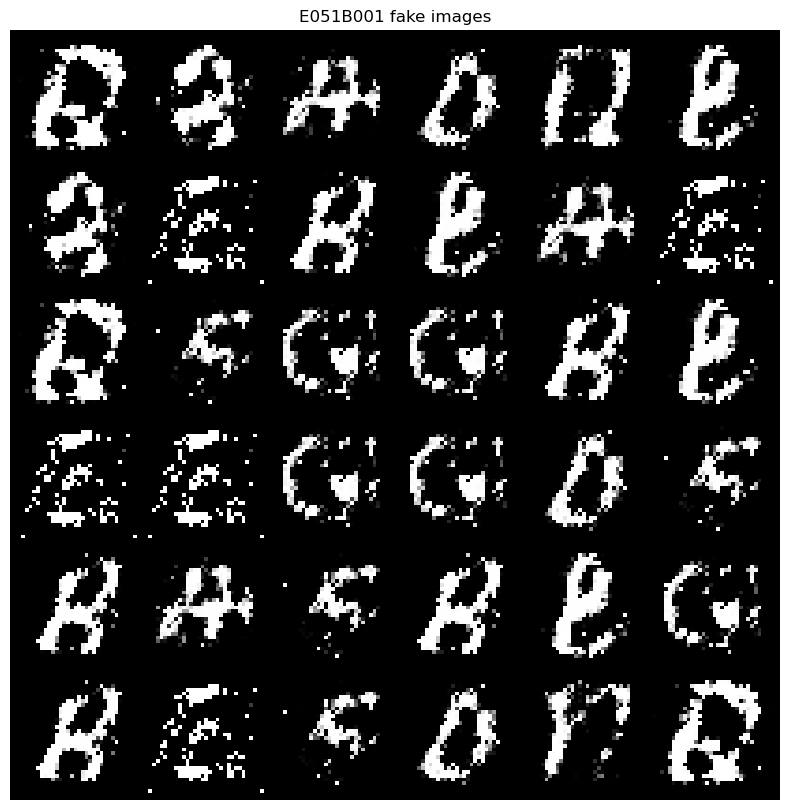

 E051B933, [0:14:03/0:27:33] 16.22s/epoch D_loss: 0.1905 = r0.3263 + f0.0548  G_loss: 4.3737

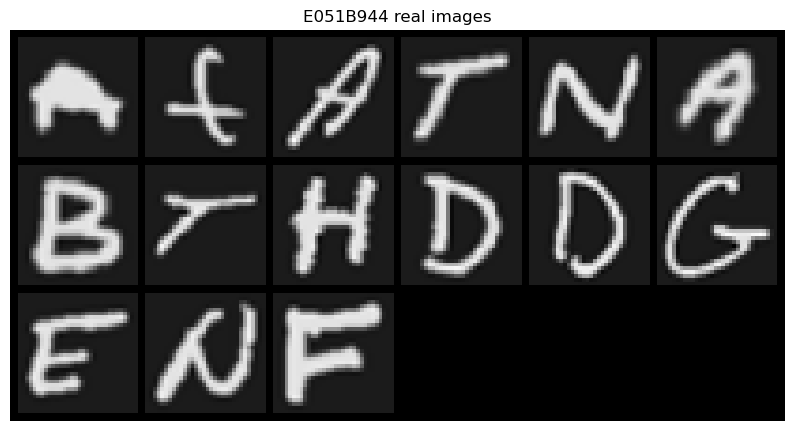

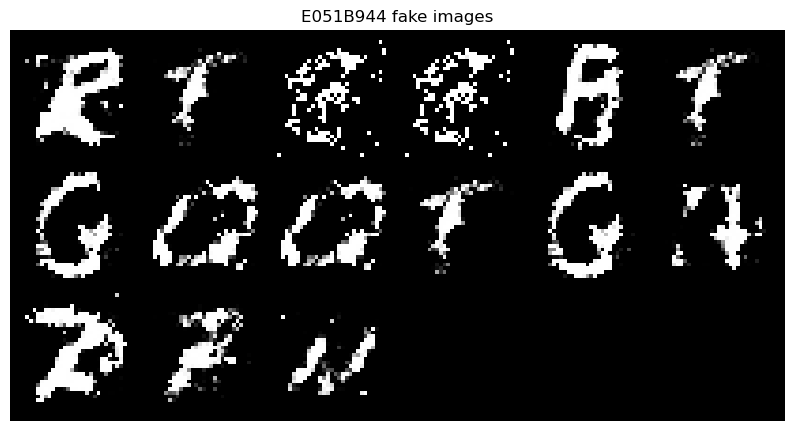

 E060B942, [0:16:31/0:27:32] 16.25s/epoch D_loss: 0.5990 = r1.1839 + f0.0141  G_loss: 7.51094

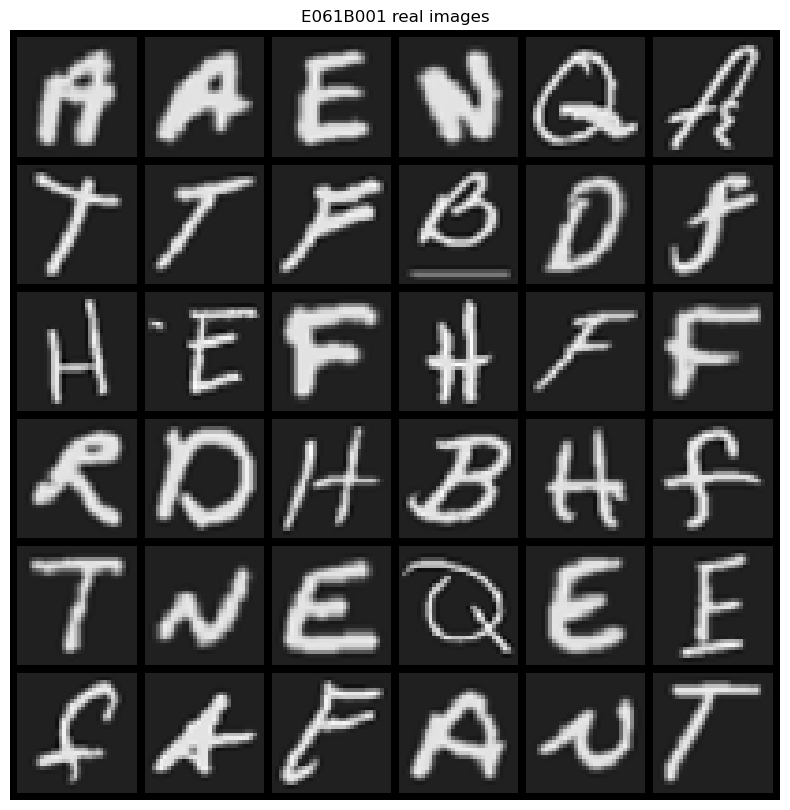

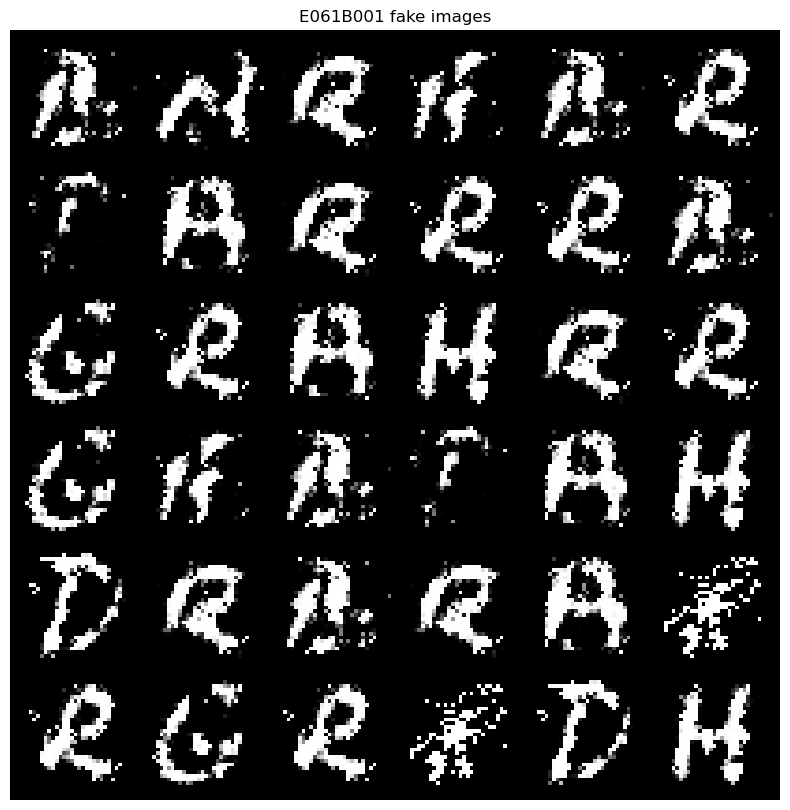

 E061B943, [0:16:47/0:27:32] 16.26s/epoch D_loss: 0.2177 = r0.1072 + f0.3281  G_loss: 2.3525

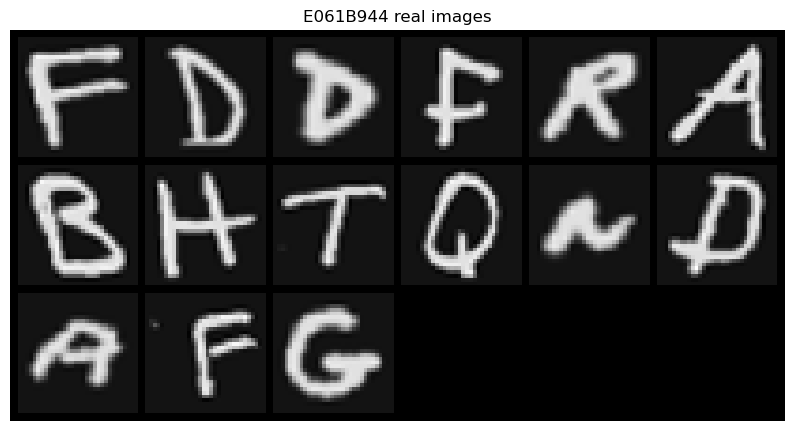

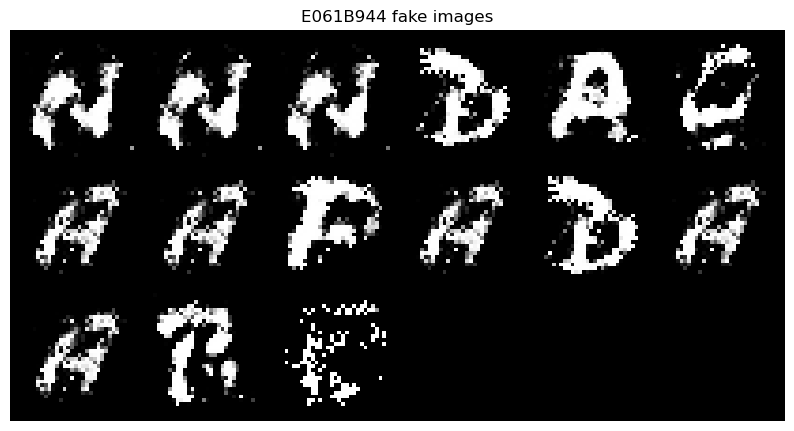

 E070B931, [0:19:15/0:27:30] 16.28s/epoch D_loss: 0.1925 = r0.3514 + f0.0336  G_loss: 5.2583

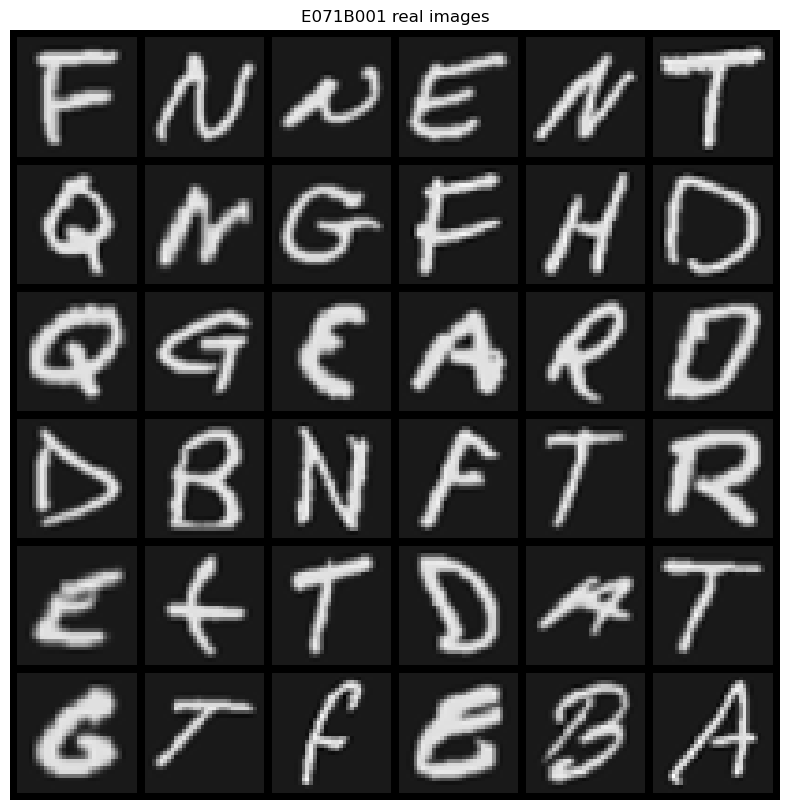

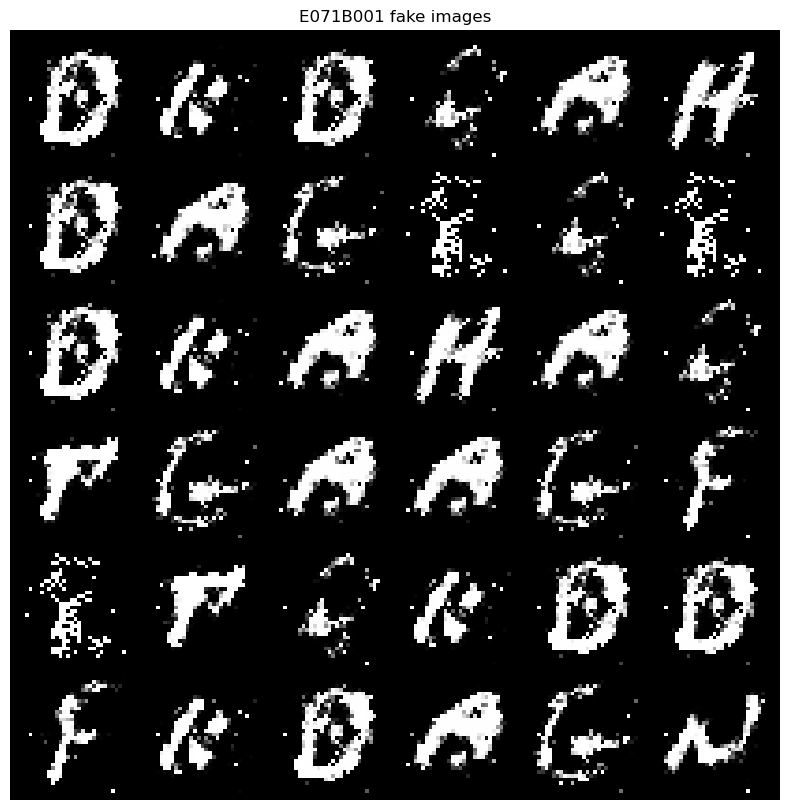

 E071B932, [0:19:31/0:27:30] 16.28s/epoch D_loss: 0.1193 = r0.1563 + f0.0823  G_loss: 4.4330

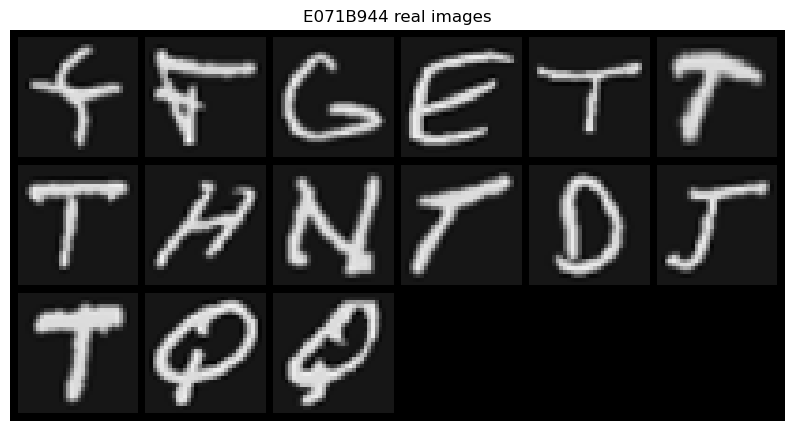

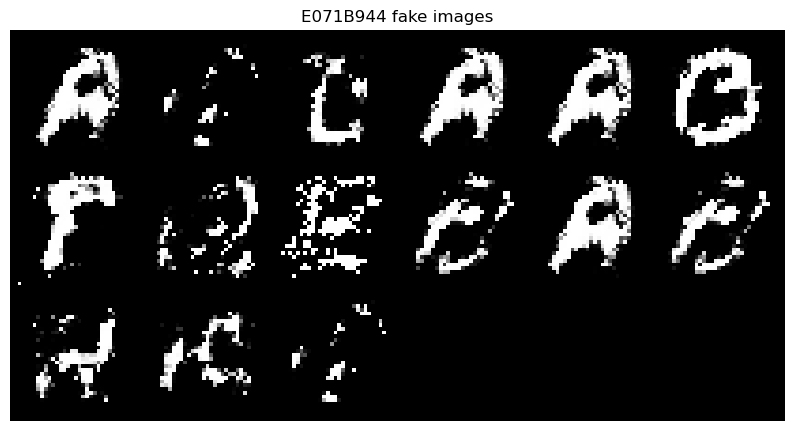

 E080B941, [0:21:59/0:27:29] 16.30s/epoch D_loss: 0.1511 = r0.2663 + f0.0359  G_loss: 4.2905

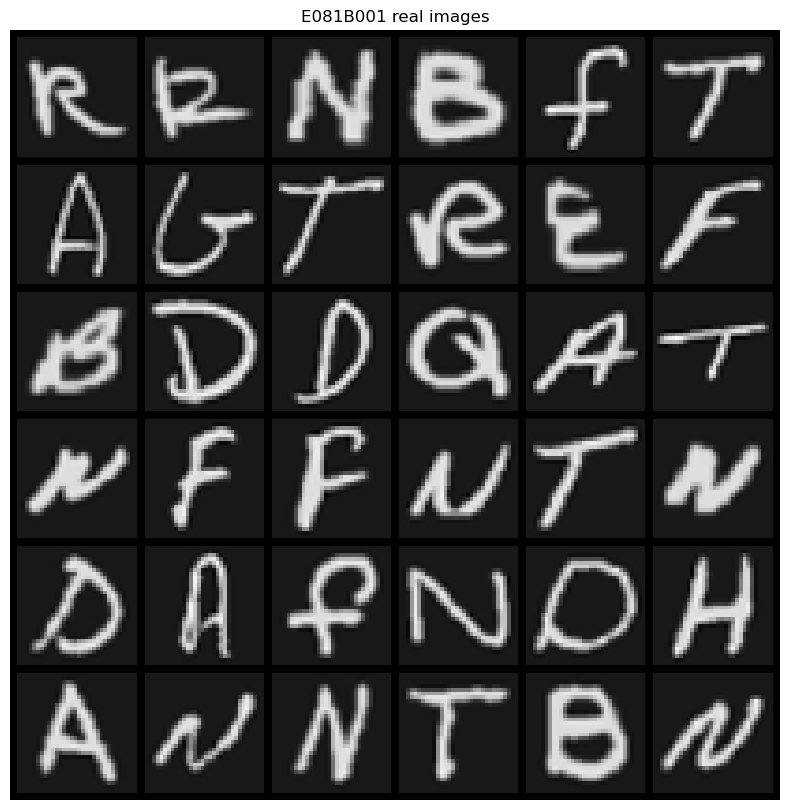

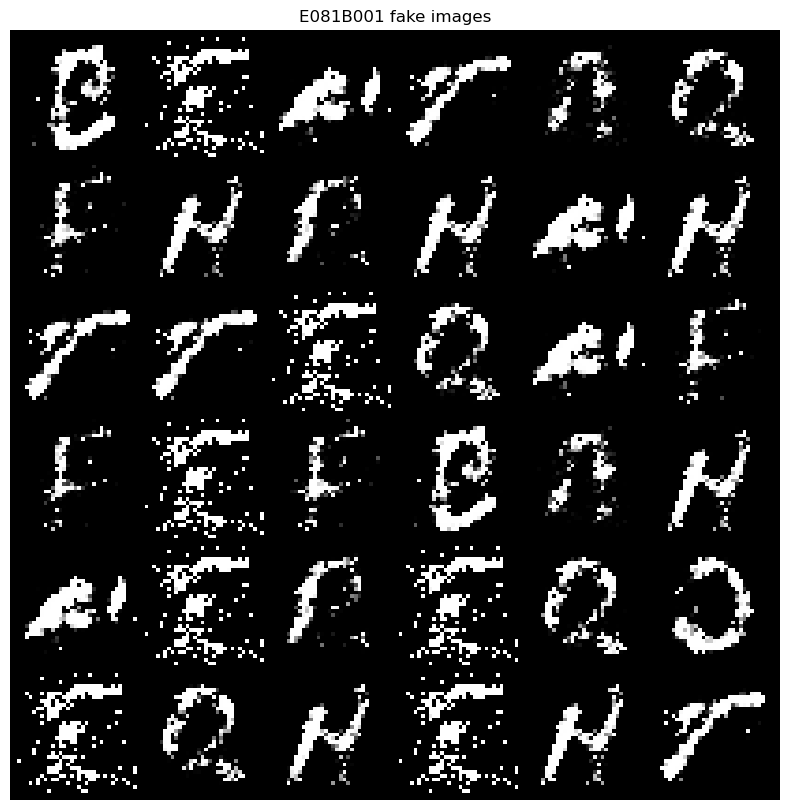

 E081B942, [0:22:16/0:27:30] 16.30s/epoch D_loss: 0.2324 = r0.2244 + f0.2404  G_loss: 3.2817

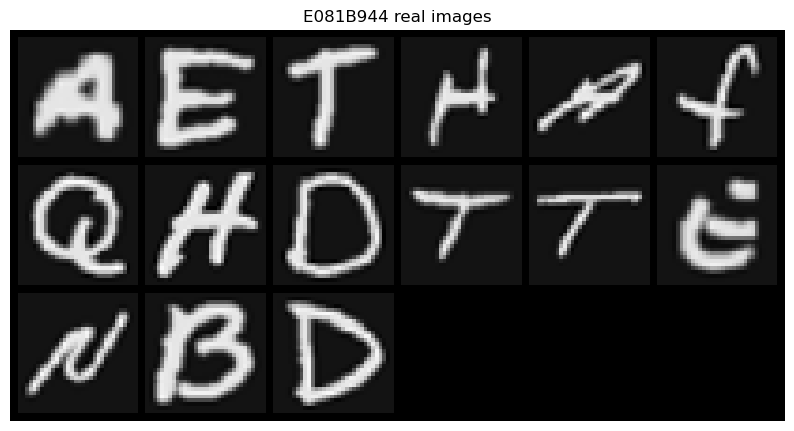

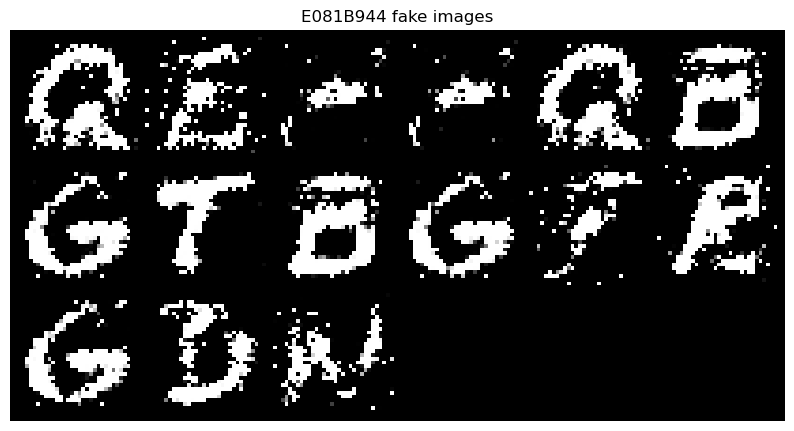

 E090B930, [0:24:43/0:27:28] 16.31s/epoch D_loss: 0.1825 = r0.2808 + f0.0842  G_loss: 4.2201

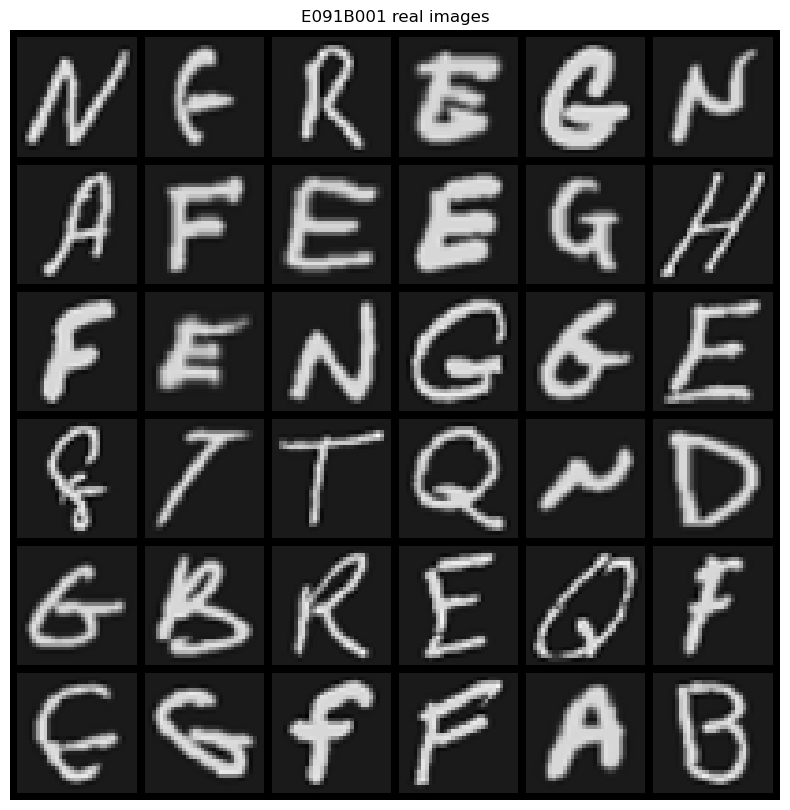

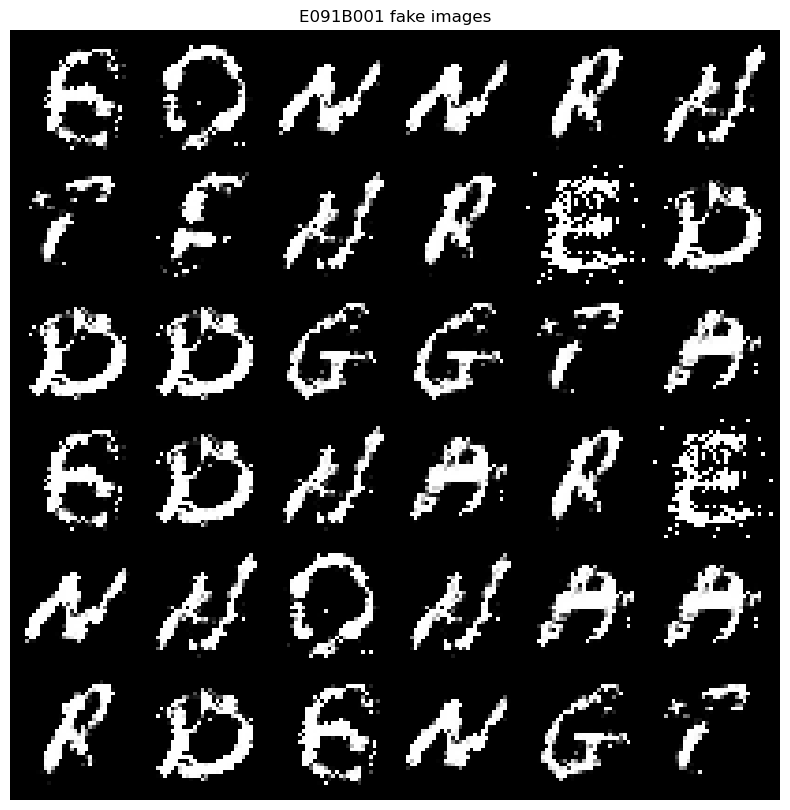

 E091B931, [0:25:00/0:27:29] 16.31s/epoch D_loss: 0.3386 = r0.5043 + f0.1729  G_loss: 4.0394

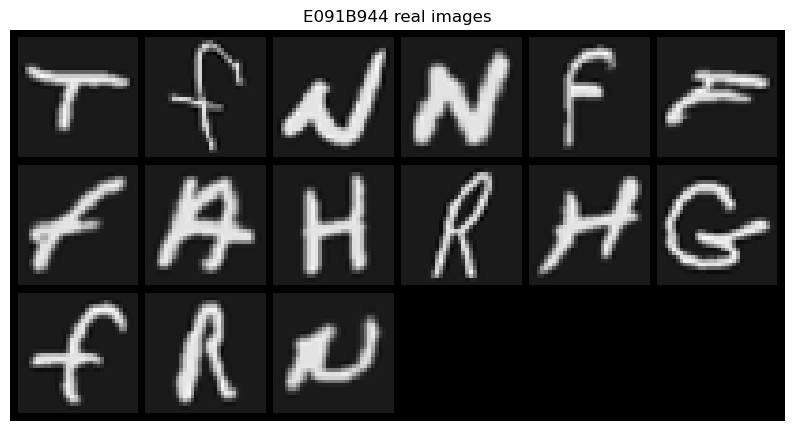

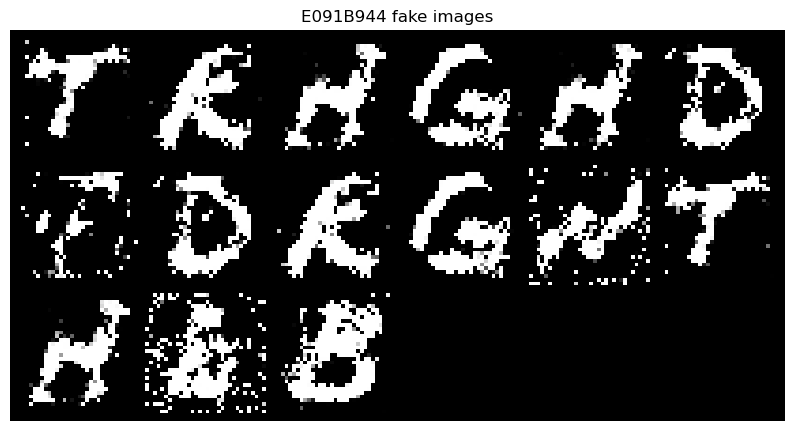

 E100B940, [0:27:29/0:27:29] 16.33s/epoch D_loss: 0.3246 = r0.1700 + f0.4792  G_loss: 2.41756

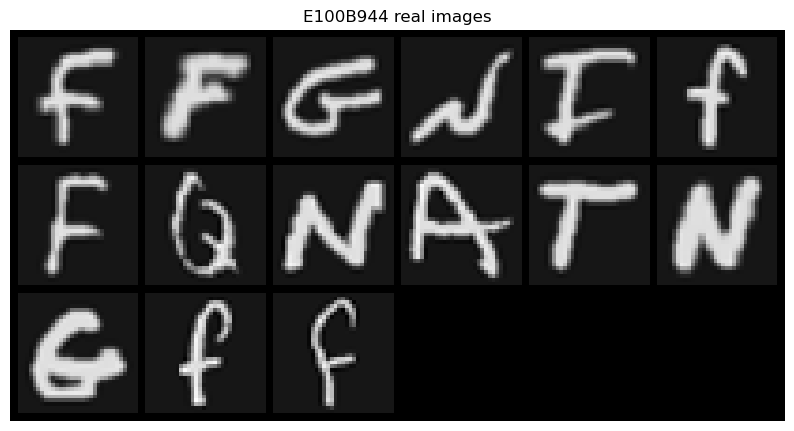

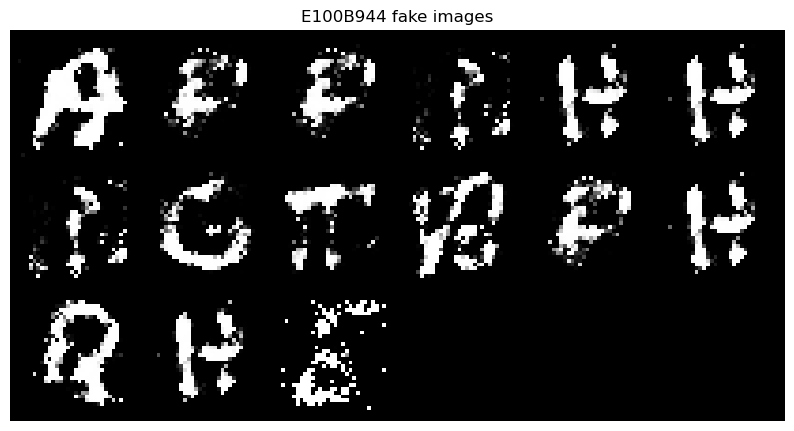

In [11]:
from torch.autograd import Variable
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

#  Training
result_path = './gan_CGan_bonus'
training_start = time.time()
for epoch in range(opt.n_epochs):
    loss_d_e = 0
    loss_g_e = 0
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = imgs.to(device)
        labels = labels.long().to(device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = torch.randn(imgs.size(0), opt.latent_dim).to(device)
        gen_labels = torch.from_numpy(np.random.choice(a=bonus_classes, size=batch_size, replace=True)).long().to(device)
        # Generate a batch of images
        fake_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(fake_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(fake_imgs.detach(), gen_labels)
        fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()


        loss_d_e += d_loss.item()
        loss_g_e += g_loss.item()
        batches_done = epoch * len(dataloader) + i

        if batches_done % (opt.sample_interval // 100 + 1) == 0:
            diff = time.time() - training_start
            a_td = to_td(diff)
            al_td = to_td(diff * opt.n_epochs * len(dataloader) / (epoch * len(dataloader) + i + 1))
            per_df = diff / (epoch + 1 + i / len(dataloader))

            print(f"\r E{epoch+1:03}B{i+1:03}, [{a_td}/{al_td}] {per_df:5.2f}s/epoch",
                  f"D_loss: {d_loss.item():6.4f} = r{real_loss.item():6.4f} + f{fake_loss.item():6.4f}",
                  f" G_loss: {g_loss.item():6.4f}",
                  end="")

        if batches_done % opt.sample_interval == 0 and epoch % 5 == 0:
            if batches_done > 10:
                torch.save(generator.state_dict(), weights_root / f"E{epoch+1:03}B{i+1:03}G.pth")
                torch.save(discriminator.state_dict(), weights_root / f"E{epoch+1:03}B{i+1:03}D.pth")
        if (epoch % 10 == 0) and (i == 0 or i == len(dataloader) - 1):        
            show_images(real_imgs, fake_imgs, save=True, name=f"E{epoch+1:03}B{i+1:03} ")
        #  final model and result
        if (epoch == opt.n_epochs - 1) and (i == len(dataloader) - 1):
            if not os.path.isdir(result_path):
                os.mkdir(result_path)
            torch.save(generator.state_dict(), result_path + "/Generator weights.pth")
            torch.save(discriminator.state_dict(), result_path + "/Discriminator weights.pth")
            show_images(real_imgs, fake_imgs, save=True, name=f"E{epoch+1:03}B{i+1:03} ")
    record["D_loss"].append(loss_d_e / len(dataloader))
    record["G_loss"].append(loss_g_e / len(dataloader))

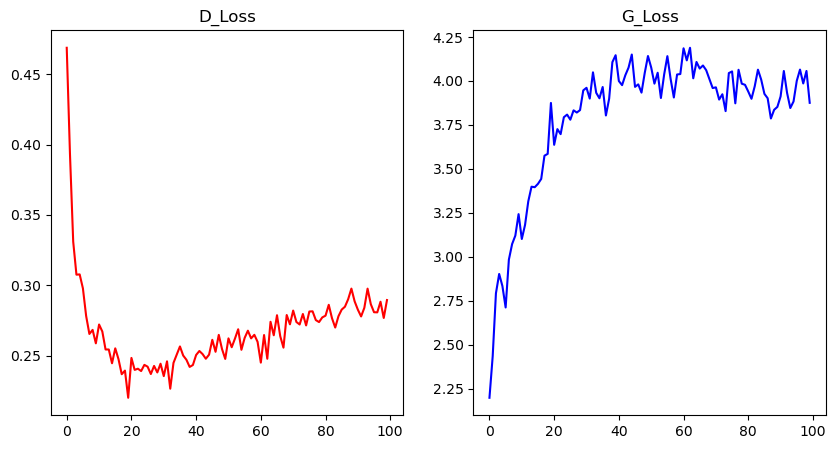

In [12]:
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(record["D_loss"], 'r')   # red line w ithout marker
plt.title('D_Loss')
plt.subplot(122)
plt.plot( record["G_loss"], 'b') # blue solid line with filled circle marker
plt.title('G_Loss')
plt.savefig('CGan_Bonus_Loss.png')
plt.show()

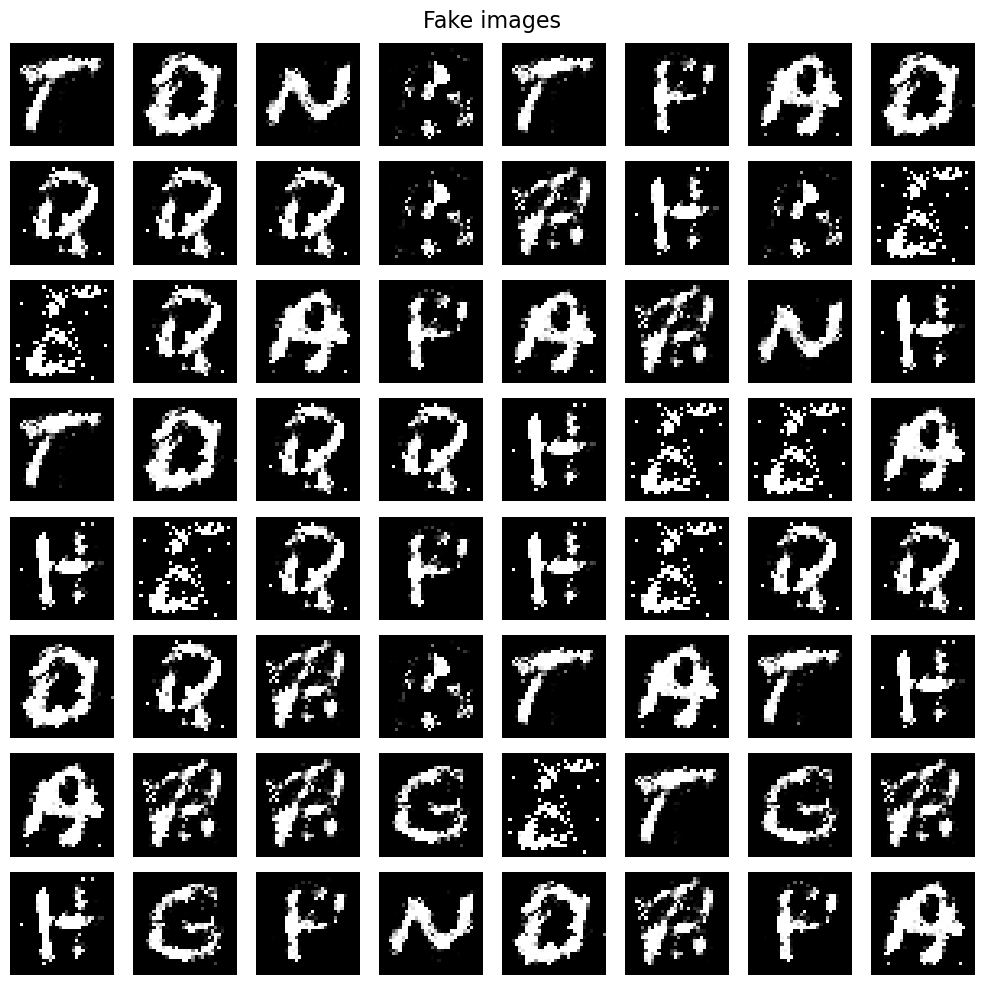

In [14]:
generator = Generator()

generator.load_state_dict(torch.load(result_path + "/Generator weights.pth"))
generator.eval()
z = torch.randn(opt.batch_size, opt.latent_dim)
gen_labels = torch.from_numpy(np.random.choice(a=bonus_classes, size=opt.batch_size, replace=True)).long()
fake_imgs = generator(z, gen_labels)
fake_imgs.shape

fake_imgs = fake_imgs.view(fake_imgs.size(0), opt.channels, opt.img_size, opt.img_size)

fig, axs = plt.subplots(8, 8, figsize=(10, 10))

for i, ax in enumerate(axs.flatten()):
    if i < len(fake_imgs):
        ax.imshow(fake_imgs[i].detach().numpy().squeeze(), cmap='gray')
        ax.axis('off')
    else:
        ax.remove()
fig.suptitle('Fake images', fontsize=16)
fig.tight_layout()